In [62]:
from google.colab import drive
drive.mount("content/")

Drive already mounted at content/; to attempt to forcibly remount, call drive.mount("content/", force_remount=True).


# Imports

In [63]:
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, confusion_matrix
import random
from random import sample


import os.path as osp
import glob
from random import shuffle

import cv2 as cv
from google.colab.patches import cv2_imshow


import keras
from keras.models import load_model
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPooling2D,GlobalMaxPooling2D
from keras import backend as K
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU


import matplotlib.pyplot as plt


### Get the image paths and the corresponding labels of the images in the path

In [64]:
def get_image_paths(data_path, categories, num_train_per_cat, fmt):
  """
      Parameters:
        param data_path: path to the 'test' and 'train' directories
        param categories: list of category names
        param num_train_per_cat: max number of training images to use (per category)
        param fmt: file extension of the images
        return: lists: train_image_paths, test_image_paths, train_labels, test_labels
  """
  train_image_paths = []
  test_image_paths = []
  train_labels = []
  test_labels = []

  for cat in categories:
    
    pth = osp.join(data_path,cat, '*{:s}'.format(fmt))
    pth = glob.glob(pth,recursive = True)
    shuffle(pth)
    train_pth = pth[:int(num_train_per_cat*len(pth))]
    test_pth = pth[int(num_train_per_cat*len(pth)):]

    train_image_paths.extend(train_pth)
    train_labels.extend([cat]*len(train_pth))
    test_image_paths.extend(test_pth)
    test_labels.extend([cat]*len(test_pth))

  return train_image_paths, test_image_paths, train_labels, test_labels


## Gets images from paths

In [65]:
def get_images(paths):
  images=[]
  for path in paths:
    images.append(cv.imread(path,0))
  
  return images


## Resize images

In [66]:
def resize_images(images,image_size):
  for i in range(len(images)):
   images[i]=cv.resize(images[i],(image_size,image_size))
  return images

## Get the categories of task1test

In [67]:
def get_categories_task1test(numberoflabels):
  categories = []
  for i in range(1,numberoflabels+1):
    if i <10:
      string="".join(['Sample00',str(i)])
    else:
      string="".join(['Sample0',str(i)])
    categories.append(string)
  return categories

### The below function transforms the images from standard Mnist data set where the background is in black and the digits are written in white which is in contrary to the images provided in task, into images where background is white and the numbers are written in black so that the given images and mnist imageshave the same background and font colour whenever we need to use the Mnist  data  with given data.

In [68]:
def transform_test(images):
  for image in images:
    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        image[i][j]=255-image[i][j]
  return images

## One hot encoding of categories

In [69]:
def transform_categories(data,categories,numoflabels):
  """
    Parameters:
      data: The concerned data
      categories: classes in the data
      numoflabels
        

  """
  labelencoder = LabelEncoder()
  labelencoder.fit(categories)
  data=labelencoder.transform(data)
  data = keras.utils.to_categorical(data, numoflabels)

  return data

### Normalize and Reshape the input data

In [70]:
def normalize_reshape(data):
  """
    Parameters:
      data: The concerned data
  """
  data=np.asarray(data)/255
  data=data.reshape(-1, data.shape[1], data.shape[2], 1).astype('float32')
  return data

### I have used the below model through out the experiments


In [71]:
def  get_model(input_size,num_classes,adam_alpha):
  """
      Parameters:
        input_size:  tuple consisiting of the shape of each image matrix
        num_classes: Number of classes to classify
        adam_alpha:  Parameter for the otpimizer

  """

  model = Sequential()
  model.add(Conv2D(32,(5,5),padding='same',activation='relu',input_shape=(input_size[0],input_size[1],1)))
  model.add(LeakyReLU(alpha=.2))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(.2))
  model.add(Conv2D(128,(5,5)))
  model.add(LeakyReLU(alpha=.2))    
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(.2))
  model.add(GlobalMaxPooling2D())   
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=.2))
  model.add(Dropout(.2))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=.2))
  model.add(Dropout(.2))      
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(adam_alpha),metrics=['accuracy'])

  return model

# Experiments:

# Part 1

In [72]:
categories=get_categories_task1test(62)# Getting the 62 categroies

In [73]:
data_path = osp.join("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/")


In [74]:
data_path

'/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/'

In [75]:
num_train_per_cat = 0.8

In [76]:
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(data_path,categories,num_train_per_cat,'.png')

In [86]:
train_labels=transform_categories(train_labels,categories,62)
test_labels=transform_categories(test_labels,categories,62)

In [87]:
train_images=get_images(train_image_paths)

train_images=resize_images(train_images,224)

In [88]:
train_images=normalize_reshape(train_images)

In [89]:
train_images.shape

(1984, 224, 224, 1)

In [90]:
test_images=get_images(test_image_paths)

test_images=resize_images(test_images,224)


In [91]:
test_images=normalize_reshape(test_images)

In [92]:
test_images.shape

(496, 224, 224, 1)

In [93]:
model = get_model((224,224),62,0.001)

In [94]:
checkpoint = ModelCheckpoint(filepath="/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, save_weights_only=True, mode='max')
history = model.fit(train_images,train_labels,epochs = 50 , validation_data = (test_images,test_labels),batch_size=10,shuffle=True,callbacks=[checkpoint])

Epoch 1/50
199/199 [==============================] - 7s 32ms/step - loss: 4.1479 - accuracy: 0.0216 - val_loss: 4.1206 - val_accuracy: 0.0383

Epoch 00001: val_accuracy improved from -inf to 0.03831, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint.hdf5
Epoch 2/50
199/199 [==============================] - 6s 31ms/step - loss: 3.9606 - accuracy: 0.0368 - val_loss: 3.3112 - val_accuracy: 0.0948

Epoch 00002: val_accuracy improved from 0.03831 to 0.09476, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint.hdf5
Epoch 3/50
199/199 [==============================] - 6s 31ms/step - loss: 3.0759 - accuracy: 0.1440 - val_loss: 2.3652 - val_accuracy: 0.3226

Epoch 00003: val_accuracy improved from 0.09476 to 0.32258, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint.hdf5
Epoch 4/50
199/199 [==============================] - 6s 31ms/step - loss: 2.1204 - accuracy: 

### Plot

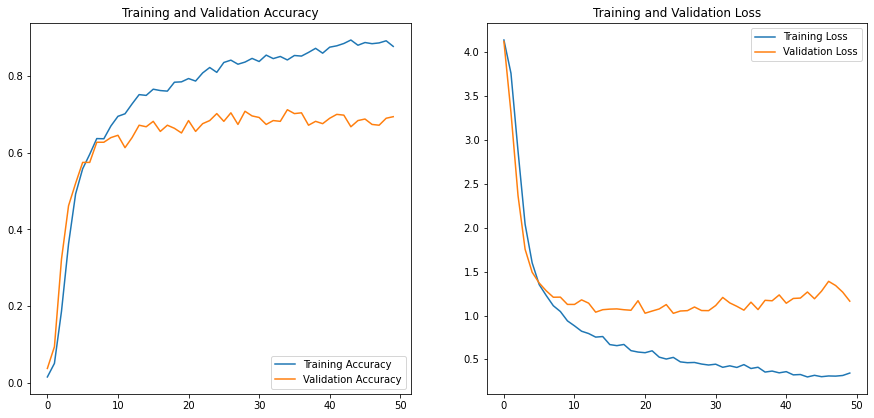

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/task21.png")
plt.show()

# Comment:
## Here the low accuracies are due to large number of classes with less example in hand per class

# Part2

## Load Mnist data

In [108]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


### Pre-processing Mnist

In [109]:
x_train =normalize_reshape(x_train)
x_test = normalize_reshape(x_test)

num_classes=10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [110]:
x_train.shape

(60000, 28, 28, 1)

In [111]:
x_test.shape

(10000, 28, 28, 1)

In [112]:
y_train.shape

(60000, 10)

In [113]:
model = get_model((28,28),10,0.001)

### Part2 case 1: Training a model using Mnist dataset

In [114]:
checkpoint = ModelCheckpoint(filepath="/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint2.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(x_train, y_train,epochs = 20 , validation_data = (x_test,y_test),batch_size=500,shuffle=True,callbacks=[checkpoint])

Epoch 1/20
120/120 [==============================] - 140s 1s/step - loss: 1.1379 - accuracy: 0.6157 - val_loss: 0.0920 - val_accuracy: 0.9752

Epoch 00001: val_accuracy improved from -inf to 0.97520, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint2.hdf5
Epoch 2/20
120/120 [==============================] - 139s 1s/step - loss: 0.1216 - accuracy: 0.9634 - val_loss: 0.0589 - val_accuracy: 0.9829

Epoch 00002: val_accuracy improved from 0.97520 to 0.98290, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint2.hdf5
Epoch 3/20
120/120 [==============================] - 139s 1s/step - loss: 0.0865 - accuracy: 0.9733 - val_loss: 0.0462 - val_accuracy: 0.9865

Epoch 00003: val_accuracy improved from 0.98290 to 0.98650, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint2.hdf5
Epoch 4/20
120/120 [==============================] - 138s 1s/step - loss: 0.0619 - accurac

In [115]:
model = load_model("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint2.hdf5")

#### Making prediction

In [116]:
y_pred=model.predict(x_test)

### Accuracy Score

In [117]:
accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))

0.9937

### Precision Score

In [118]:
precision_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')


0.9937157185546132

### Recall Score

In [119]:
recall_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')


0.9937

### F1 Score

In [120]:
f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')


0.9937001461879638

### Confusion Matrix

In [121]:
confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1),labels=list(range(10)))

array([[ 973,    0,    1,    0,    0,    0,    5,    1,    0,    0],
       [   0, 1131,    1,    1,    0,    0,    2,    0,    0,    0],
       [   1,    0, 1030,    0,    0,    0,    0,    0,    1,    0],
       [   0,    0,    1, 1004,    0,    5,    0,    0,    0,    0],
       [   0,    0,    0,    0,  980,    0,    0,    1,    0,    1],
       [   1,    0,    1,    4,    0,  885,    1,    0,    0,    0],
       [   2,    3,    0,    0,    1,    0,  952,    0,    0,    0],
       [   0,    4,    5,    0,    1,    0,    0, 1016,    0,    2],
       [   2,    0,    1,    0,    0,    1,    1,    0,  967,    2],
       [   0,    0,    3,    0,    5,    0,    1,    1,    0,  999]])

### Plot

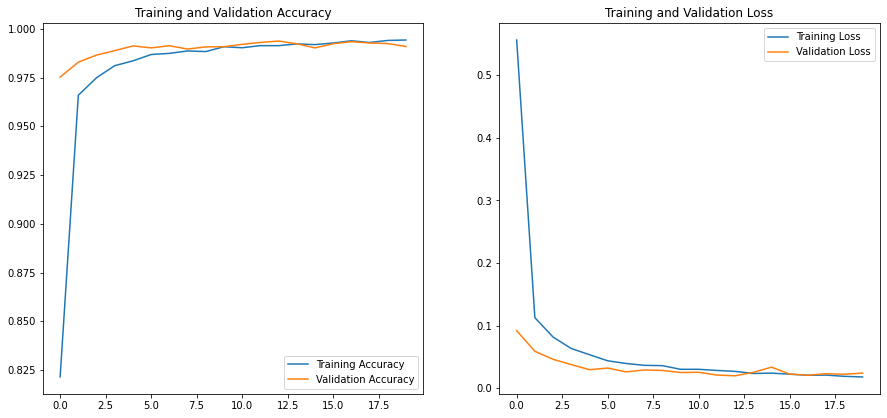

In [122]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/task221.png")
plt.show()

### Part2 case 2: Pre-training a model using the data in Part 1 and the training and testing with the Mnist data




#### Loading Mnist

In [223]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


### Using a sample of 100 point randomly from the test set of the Mnist for the purpose of validation during the pre-training

In [1]:
sample_indices=sample(list(range(len(x_test))),100)

In [225]:
x_test_sample=np.array([x_test[i] for i in sample_indices])
y_test_sample=np.array([y_test[i] for i in sample_indices])

In [226]:
cv2_imshow(x_test_sample[0])

## The images in mnist is with black background and white font while it is the opossite with the part 1 data, so here the images in the mnist transformed into the same font and background as it is with the given data in part 1

In [227]:
x_test_sample=transform_test(x_test_sample)

In [228]:
cv2_imshow(x_test_sample[0])

In [229]:
x_train=normalize_reshape(x_train)
x_test=normalize_reshape(x_test)

x_test=normalize_reshape(x_test)
x_test_sample=normalize_reshape(x_test_sample)

In [230]:
y_train=keras.utils.to_categorical(y_train, 10)
y_test=keras.utils.to_categorical(y_test, 10)
y_test_sample=keras.utils.to_categorical(y_test_sample, 10)

In [231]:
categories=get_categories_task1test(10)# Getting the 62 categroies

In [165]:
num_train_per_cat =1
data_path = osp.join("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/")
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(data_path,categories,num_train_per_cat,'.png')
train_labels=transform_categories(train_labels,categories,10)

In [166]:
train_images=get_images(train_image_paths)

train_images=resize_images(train_images,28)

In [167]:
train_images=normalize_reshape(train_images)

In [168]:
train_images.shape

(400, 28, 28, 1)

In [169]:
train_labels.shape

(400, 10)

In [170]:
y_test_sample.shape

(100, 10)

## Pre-training using data from part1 of the task

In [11]:
model=get_model((28,28),10,0.001)

In [191]:
checkpoint = ModelCheckpoint(filepath="/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint3.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_images,train_labels,epochs = 50,validation_data = (x_test_sample,y_test_sample),batch_size=10,shuffle=True,callbacks=[checkpoint])

Epoch 1/50
40/40 [==============================] - 1s 9ms/step - loss: 2.3504 - accuracy: 0.0794 - val_loss: 2.2989 - val_accuracy: 0.1400

Epoch 00001: val_accuracy improved from -inf to 0.14000, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint3.hdf5
Epoch 2/50
40/40 [==============================] - 0s 5ms/step - loss: 2.2927 - accuracy: 0.1199 - val_loss: 2.2841 - val_accuracy: 0.2400

Epoch 00002: val_accuracy improved from 0.14000 to 0.24000, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint3.hdf5
Epoch 3/50
40/40 [==============================] - 0s 5ms/step - loss: 2.1775 - accuracy: 0.2997 - val_loss: 1.8801 - val_accuracy: 0.3200

Epoch 00003: val_accuracy improved from 0.24000 to 0.32000, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint3.hdf5
Epoch 4/50
40/40 [==============================] - 0s 5ms/step - loss: 1.4239 - accuracy: 0.4786 - 

## Training and testing the pre-trained model using the train and test split of the standard Mnist

In [123]:
model = load_model("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint3.hdf5")

In [124]:
checkpoint = ModelCheckpoint(filepath="/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint4.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(x_train,y_train,epochs = 20,validation_data = (x_test,y_test),batch_size=500,shuffle=True,callbacks=[checkpoint])

Epoch 1/20
120/120 [==============================] - 137s 1s/step - loss: 0.9371 - accuracy: 0.7471 - val_loss: 0.1802 - val_accuracy: 0.9473

Epoch 00001: val_accuracy improved from -inf to 0.94730, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint4.hdf5
Epoch 2/20
120/120 [==============================] - 137s 1s/step - loss: 0.1784 - accuracy: 0.9448 - val_loss: 0.1006 - val_accuracy: 0.9723

Epoch 00002: val_accuracy improved from 0.94730 to 0.97230, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint4.hdf5
Epoch 3/20
120/120 [==============================] - 137s 1s/step - loss: 0.1272 - accuracy: 0.9599 - val_loss: 0.0862 - val_accuracy: 0.9754

Epoch 00003: val_accuracy improved from 0.97230 to 0.97540, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint4.hdf5
Epoch 4/20
120/120 [==============================] - 137s 1s/step - loss: 0.1023 - accurac

In [125]:
model = load_model("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint4.hdf5")

#### Making prediction

In [126]:
y_pred=model.predict(x_test)

### Accuracy Score

In [127]:
accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))

0.99

### Precision Score

In [128]:
precision_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')


0.9900567636802676

### Recall Score

In [129]:
recall_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')


0.99

### F1 Score

In [130]:
f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')


0.989998207764675

### Confusion matrix

In [131]:
confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1),labels=list(range(10)))

array([[ 976,    0,    2,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1130,    2,    0,    1,    1,    0,    1,    0,    0],
       [   0,    1, 1028,    0,    1,    0,    0,    2,    0,    0],
       [   0,    1,    3, 1002,    0,    2,    0,    1,    1,    0],
       [   0,    0,    0,    0,  979,    0,    0,    1,    0,    2],
       [   1,    0,    3,    9,    0,  876,    1,    1,    0,    1],
       [   2,    6,    1,    0,    1,    5,  940,    0,    3,    0],
       [   0,    4,    6,    0,    0,    0,    0, 1017,    0,    1],
       [   1,    1,    3,    0,    2,    1,    0,    0,  964,    2],
       [   2,    1,    2,    0,   14,    1,    0,    0,    1,  988]])

### Plot

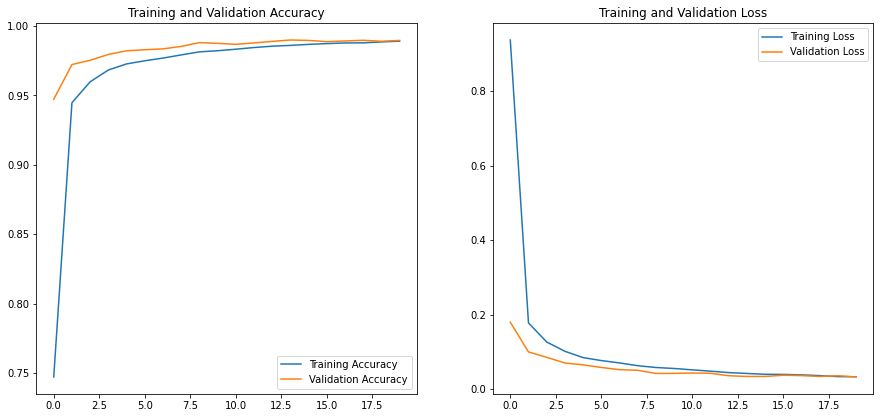

In [132]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/task22.png")
plt.show()

# Comment
### Both the approaches here yield a similar training quality and convergence time ,this is due to large number of training examples per class in the standard mnist dataset.

# Part3

In [30]:
categories=[str(i) for i in range(0,10)]

In [ ]:
data_path = osp.join("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/mnistTask3/mnistTask")
num_train_per_cat=1
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(data_path,categories,num_train_per_cat,'.jpg')

In [ ]:
train_images=get_images(train_image_paths)

train_images=resize_images(train_images,28)

In [ ]:
train_images =normalize_reshape(train_images)

In [ ]:
train_labels = keras.utils.to_categorical(train_labels_part1, 10)

### Since the mnistTask3 data is very large, saved the train data and labels after retrieving them in their array form.

In [ ]:
# with open("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/mnistTask3/train_images.pkl",'wb') as f: 
#   pickle.dump(train_images,f)


In [ ]:
# with open("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/mnistTask3/train_labels.pkl",'wb') as f: 
#   pickle.dump(train_labels,f)

In [14]:
with open("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/mnistTask3/train_images.pkl",'rb') as f:
 train_images= pickle.load(f)

In [15]:
with open("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/mnistTask3/train_labels.pkl",'rb') as f:
 train_labels= pickle.load(f)

In [16]:
train_labels = keras.utils.to_categorical(train_labels, 10)

### Loading Mnist data

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [ ]:
sample_indices=sample(list(range(len(x_test))),100)

In [ ]:
x_test_sample=np.array([x_test[i] for i in sample_indices])
y_test_sample=np.array([y_test[i] for i in sample_indices])

## The images in mnist is with black background and white font while it is the opossite with the part 1 data, so here the images in the mnist transformed into the same font and background as it is with the given data in part 1

In [ ]:
cv2_imshow(x_test_sample[0])

In [ ]:
x_test_sample=transform_test(x_test_sample)

In [ ]:
cv2_imshow(x_test_sample[0])

In [ ]:
x_train=normalize_reshape(x_train)
x_test=normalize_reshape(x_test)

x_test=normalize_reshape(x_test)
x_test_sample=normalize_reshape(x_test_sample)

In [ ]:
y_train=keras.utils.to_categorical(y_train, 10)
y_test=keras.utils.to_categorical(y_test, 10)
y_test_sample=keras.utils.to_categorical(y_test_sample, 10)

## Part3 case1: 
### Training  a model using the mnistTask3 data provided and the  validating using the Mnist test data


In [30]:
model=get_model((28,28),10,0.001)

In [31]:
checkpoint = ModelCheckpoint(filepath="/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint5.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_images,train_labels,epochs = 20,batch_size=500,validation_data = (x_test,y_test),shuffle=True,callbacks=[checkpoint])

Epoch 1/20
121/121 [==============================] - 139s 1s/step - loss: 2.3039 - accuracy: 0.1043 - val_loss: 2.5870 - val_accuracy: 0.0010

Epoch 00001: val_accuracy improved from -inf to 0.00100, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint5.hdf5
Epoch 2/20
121/121 [==============================] - 138s 1s/step - loss: 2.2800 - accuracy: 0.1119 - val_loss: 3.2840 - val_accuracy: 4.0000e-04

Epoch 00002: val_accuracy did not improve from 0.00100
Epoch 3/20
121/121 [==============================] - 138s 1s/step - loss: 2.2521 - accuracy: 0.1137 - val_loss: 3.8249 - val_accuracy: 4.0000e-04

Epoch 00003: val_accuracy did not improve from 0.00100
Epoch 4/20
121/121 [==============================] - 138s 1s/step - loss: 2.2372 - accuracy: 0.1163 - val_loss: 4.1648 - val_accuracy: 2.0000e-04

Epoch 00004: val_accuracy did not improve from 0.00100
Epoch 5/20
121/121 [==============================] - 138s 1s/step - loss: 2.2280 - accura

In [32]:
model = load_model("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint5.hdf5")

#### Making prediction

In [33]:
y_pred=model.predict(x_test)

### Accuracy Score

In [34]:
accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))

0.001

### Precision Score

In [35]:
precision_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')

0.0009676446096254541

### Recall Score

In [36]:
recall_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')

0.001

### F1 Score

In [37]:
f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')

0.0005140614980021833

### Confusion Matrix

In [38]:
confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1),labels=list(range(10)))

array([[  0, 347,  28,   5,   5,   1,   2,   8,   0, 584],
       [ 21,   8,   0,  11, 164, 432, 451,   1,   0,  47],
       [ 31, 976,   1,   0,   1,   0,  20,   0,   0,   3],
       [ 90, 362,   0,   0,   0,   0, 556,   2,   0,   0],
       [178, 773,  20,   1,   0,   5,   3,   2,   0,   0],
       [ 23, 708,   0,   2,  20,   0, 132,   1,   0,   6],
       [ 15, 869,   0,  11,   1,   1,   1,  24,   0,  36],
       [ 37, 789,   1,  27,   0,  34, 115,   0,  25,   0],
       [179, 344,  33,   0,  50,   0, 125, 239,   0,   4],
       [180, 721,  55,   1,   0,   2,  50,   0,   0,   0]])

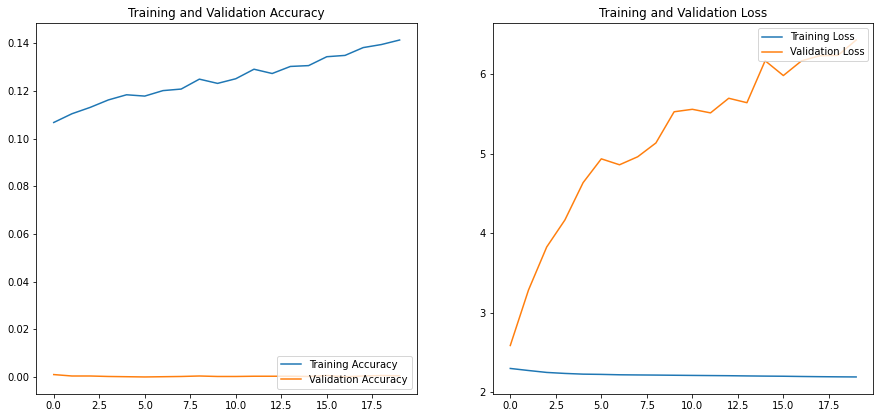

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/task231.png")
plt.show()

# Comment
## Training using the misclassified mnistTask3 dataset and validating using  the standard Mnist test set fails miserably.

## Part3 case2: 
### Pre-training a model using the data in Part1, training  using the mnistTask3 data provided and the  testing with the Mnist test data


In [55]:
categories=get_categories_task1test(10)

In [56]:
data_path = osp.join("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/")
num_train_per_cat =1
categories=get_categories_task1test(10)
train_image_paths_part1, test_image_paths_part1, train_labels_part1, test_labels_part1 = get_image_paths(data_path,categories,num_train_per_cat,'.png')
train_labels_part1=transform_categories(train_labels_part1,categories,10)


In [57]:
train_images_part1=get_images(train_image_paths_part1)

train_images_part1=resize_images(train_images_part1,28)

In [58]:
train_images_part1 =normalize_reshape(train_images_part1)

## Pre-training using the the dataset in part1 of the task

In [82]:
model=get_model((28,28),10,0.001)

In [83]:
checkpoint = ModelCheckpoint(filepath="/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint6.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_images_part1,train_labels_part1,epochs = 50,batch_size=100,validation_data = (x_test_sample,y_test_sample),shuffle=True,callbacks=[checkpoint])

Epoch 1/50
4/4 [==============================] - 1s 64ms/step - loss: 2.3314 - accuracy: 0.0690 - val_loss: 2.3137 - val_accuracy: 0.0600

Epoch 00001: val_accuracy improved from -inf to 0.06000, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint6.hdf5
Epoch 2/50
4/4 [==============================] - 0s 18ms/step - loss: 2.3180 - accuracy: 0.0920 - val_loss: 2.2977 - val_accuracy: 0.1200

Epoch 00002: val_accuracy improved from 0.06000 to 0.12000, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint6.hdf5
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 2.3103 - accuracy: 0.1087 - val_loss: 2.2969 - val_accuracy: 0.0900

Epoch 00003: val_accuracy did not improve from 0.12000
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 2.2986 - accuracy: 0.1003 - val_loss: 2.2943 - val_accuracy: 0.1800

Epoch 00004: val_accuracy improved from 0.12000 to 0.18000, saving m

## Training using the mnistTask3 dataset and validating using the test set of the standard Mnist data

In [40]:
model = load_model("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint6.hdf5")

In [41]:
checkpoint = ModelCheckpoint(filepath="/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint7.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_images,train_labels,epochs = 20,validation_data = (x_test,y_test),batch_size=500,shuffle=True,callbacks=[checkpoint])

Epoch 1/20
121/121 [==============================] - 140s 1s/step - loss: 2.3583 - accuracy: 0.1011 - val_loss: 2.3871 - val_accuracy: 0.0076

Epoch 00001: val_accuracy improved from -inf to 0.00760, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint7.hdf5
Epoch 2/20
121/121 [==============================] - 139s 1s/step - loss: 2.2923 - accuracy: 0.1103 - val_loss: 2.5622 - val_accuracy: 8.0000e-04

Epoch 00002: val_accuracy did not improve from 0.00760
Epoch 3/20
121/121 [==============================] - 139s 1s/step - loss: 2.2815 - accuracy: 0.1128 - val_loss: 2.8016 - val_accuracy: 0.0013

Epoch 00003: val_accuracy did not improve from 0.00760
Epoch 4/20
121/121 [==============================] - 139s 1s/step - loss: 2.2703 - accuracy: 0.1123 - val_loss: 3.0067 - val_accuracy: 0.0011

Epoch 00004: val_accuracy did not improve from 0.00760
Epoch 5/20
121/121 [==============================] - 139s 1s/step - loss: 2.2598 - accuracy: 0.11

In [42]:
model = load_model("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint7.hdf5")

#### Making prediction

In [43]:
y_pred=model.predict(x_test)

### Accuracy Score

In [44]:
accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))

0.0076

### Precision Score

In [45]:
precision_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')


0.006060232196005033

### Recall Score

In [46]:
recall_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')


0.0076

### F1-score

In [47]:
f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')


0.005386782996642579

### Confusion Matrix

In [48]:
confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1),labels=list(range(10)))

array([[  0,  53,   4, 556,  44, 202,   0,   5,  26,  90],
       [ 12,   2,   7, 114,   0, 997,   1,   1,   1,   0],
       [ 99, 484,  28,  59, 113, 190,  27,   4,   9,  19],
       [ 94, 715,   2,   2, 168,   8,  13,   2,   4,   2],
       [ 76,  45, 330, 129,   1, 383,  10,   2,   5,   1],
       [ 40, 569,  14,  15, 169,  42,   9,  11,   5,  18],
       [  1, 134, 114, 587,  12,  87,   0,   3,   1,  19],
       [ 66, 152, 296,  88,   3, 409,  11,   0,   3,   0],
       [ 97, 577,  47,  81,   6, 117,  15,  23,   1,  10],
       [105, 481, 369,  20,   5,  27,   2,   0,   0,   0]])

### Plot

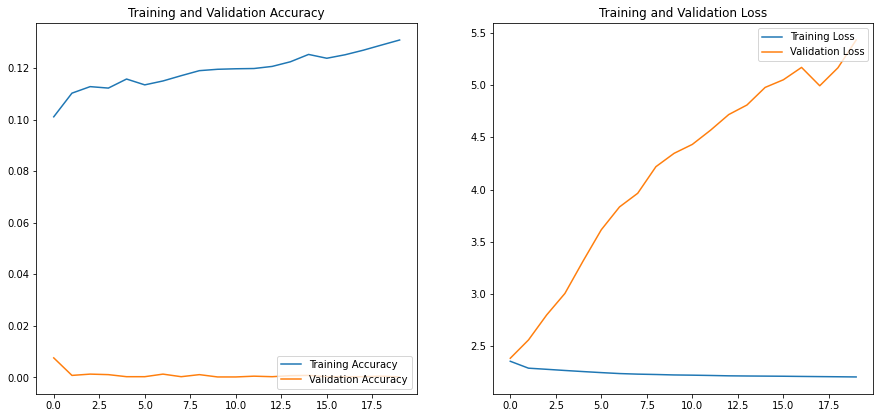

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/task232.png")
plt.show()

# Comment
### In this part we can observe that using the misclassified mnistTask3 data to train and predict the test classes of the standard Mnist fails miserably,even though the model has been pre-trained with images from part 1(also as the pre training data is not much large)

## Part3 case 3: 

### Pre-training a model using the mnistTask3 data and the training and testing with the Mnist data


## Pre-training with the mnistask3 dataset

In [50]:
model=get_model((28,28),10,0.001)

In [51]:
checkpoint = ModelCheckpoint(filepath="/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint8.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_images,train_labels,epochs = 20,validation_data = (x_test,y_test),batch_size=500,shuffle=True,callbacks=[checkpoint])

Epoch 1/20
121/121 [==============================] - 139s 1s/step - loss: 2.3024 - accuracy: 0.1032 - val_loss: 2.6857 - val_accuracy: 8.0000e-04

Epoch 00001: val_accuracy improved from -inf to 0.00080, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint8.hdf5
Epoch 2/20
121/121 [==============================] - 139s 1s/step - loss: 2.2772 - accuracy: 0.1098 - val_loss: 3.3229 - val_accuracy: 9.0000e-04

Epoch 00002: val_accuracy improved from 0.00080 to 0.00090, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint8.hdf5
Epoch 3/20
121/121 [==============================] - 139s 1s/step - loss: 2.2489 - accuracy: 0.1144 - val_loss: 3.9282 - val_accuracy: 3.0000e-04

Epoch 00003: val_accuracy did not improve from 0.00090
Epoch 4/20
121/121 [==============================] - 139s 1s/step - loss: 2.2330 - accuracy: 0.1188 - val_loss: 4.4205 - val_accuracy: 1.0000e-04

Epoch 00004: val_accuracy did not im

## Training and validating the pre-trained model using the standard train and test split of the Mnist

In [52]:
model = load_model("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint8.hdf5")

In [53]:
checkpoint = ModelCheckpoint(filepath="/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint9.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(x_train,y_train,epochs = 20,validation_data = (x_test,y_test),batch_size=500,shuffle=True,callbacks=[checkpoint])

Epoch 1/20
120/120 [==============================] - 138s 1s/step - loss: 0.9903 - accuracy: 0.6532 - val_loss: 0.1271 - val_accuracy: 0.9629

Epoch 00001: val_accuracy improved from -inf to 0.96290, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint9.hdf5
Epoch 2/20
120/120 [==============================] - 138s 1s/step - loss: 0.1274 - accuracy: 0.9609 - val_loss: 0.0629 - val_accuracy: 0.9817

Epoch 00002: val_accuracy improved from 0.96290 to 0.98170, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint9.hdf5
Epoch 3/20
120/120 [==============================] - 137s 1s/step - loss: 0.0849 - accuracy: 0.9735 - val_loss: 0.0488 - val_accuracy: 0.9855

Epoch 00003: val_accuracy improved from 0.98170 to 0.98550, saving model to /content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint9.hdf5
Epoch 4/20
120/120 [==============================] - 137s 1s/step - loss: 0.0673 - accurac

In [54]:
model = load_model("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/checkpoint9.hdf5")

#### Making prediction

In [55]:
y_pred=model.predict(x_test)

### Accuracy Score

In [56]:
accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))

0.9932

### Precision Score

In [57]:
precision_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')


0.9932131690775486

### Recall Score

In [58]:
recall_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')


0.9932

### F1 Score

In [59]:
f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')


0.9931947629511103

### Confusion Score

In [60]:
confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1),labels=list(range(10)))

array([[ 978,    0,    0,    0,    0,    0,    0,    1,    1,    0],
       [   1, 1132,    0,    1,    0,    0,    1,    0,    0,    0],
       [   1,    1, 1027,    0,    0,    0,    0,    2,    1,    0],
       [   0,    0,    0, 1006,    0,    2,    0,    2,    0,    0],
       [   0,    0,    1,    0,  977,    0,    1,    0,    2,    1],
       [   1,    0,    1,    5,    0,  883,    1,    1,    0,    0],
       [   4,    2,    0,    0,    0,    2,  948,    0,    2,    0],
       [   0,    2,    4,    0,    0,    0,    0, 1021,    0,    1],
       [   0,    0,    1,    0,    0,    1,    0,    1,  971,    0],
       [   0,    0,    1,    1,    9,    2,    1,    3,    3,  989]])

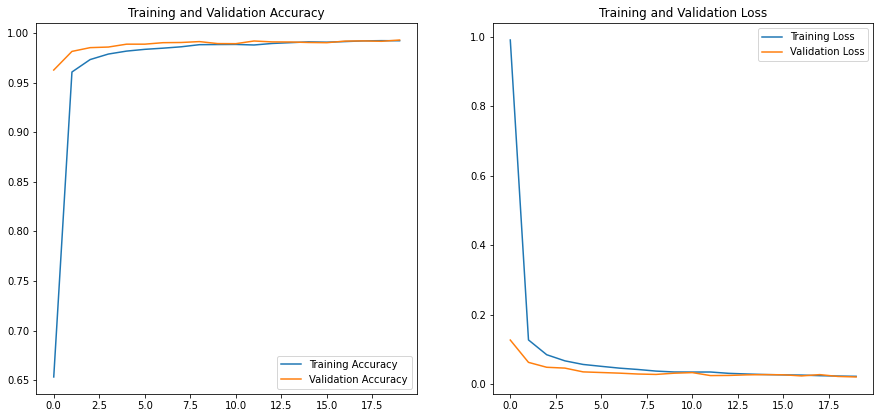

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("/content/content/MyDrive/Data/IITMIDAS/mnistTask3/Task1 test/train/task233.png")
plt.show()

# Comment
### In this part the performance using standard mnist fit and predict ( even though of pre-trained with misclassified minsitTask3 data  persists). This is due to the large number of training examples per class in the standard Mnist data.